##  Import libraries and load data

In [111]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# import warnings
# warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [112]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
full_data = [train_data, test_data]

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature engineering

In [113]:
passengerId = test_data['PassengerId']

In [114]:
for dataset in full_data:
    dataset['Name_lenght'] = dataset['Name'].apply(len)
    dataset['Has_cabin'] = dataset['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Fare'] = dataset['Fare'].fillna(train_data['Fare'].median())
    
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                                 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [115]:
drop_features = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']

train_data = train_data.drop(drop_features, axis=1)
test_data = test_data.drop(drop_features, axis=1)

In [116]:
train_data.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_lenght,Has_cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


## Visualisations

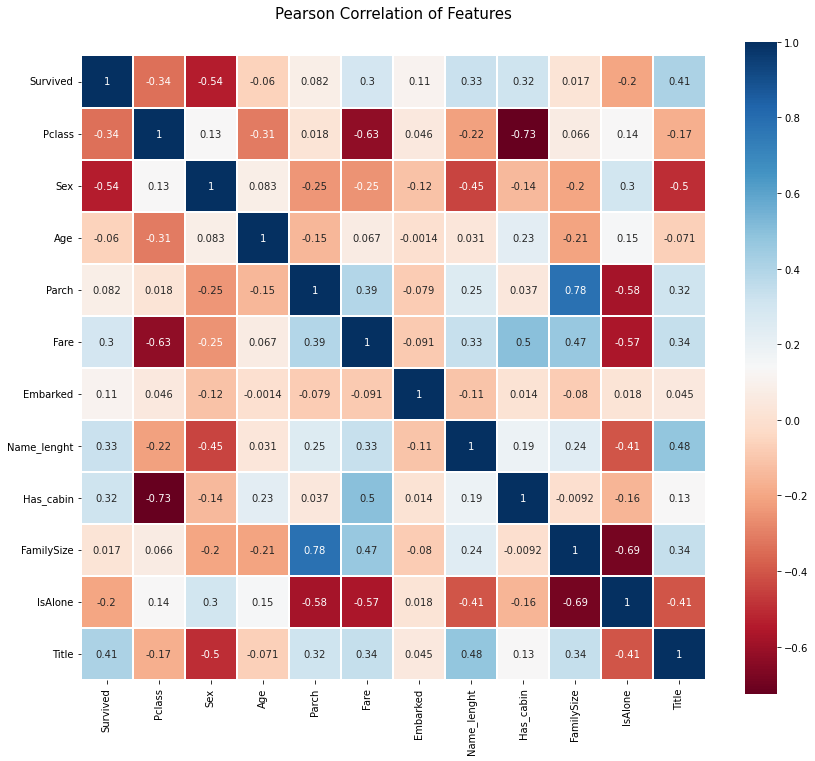

In [117]:
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True);

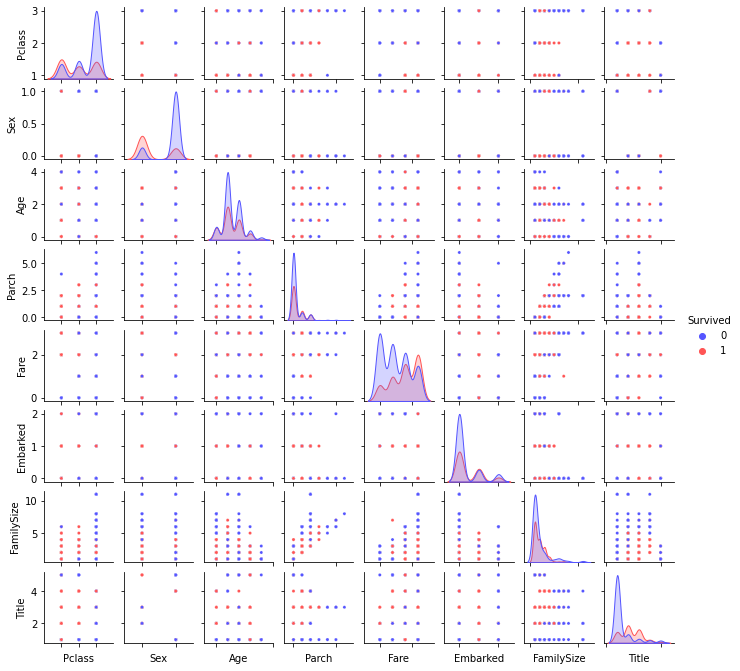

In [118]:
g = sns.pairplot(train_data[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic', size=1.2, diag_kind = 'kde',
                 diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

## Ensembling & Stacking

In [119]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
seed = 0
nfolds = 5
kf = KFold(nfolds, shuffle=True, random_state=seed)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        feature_importances = self.clf.fit(x,y).feature_importances_
        print(feature_importances)
        return feature_importances

In [120]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((nfolds, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_val = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_val)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [121]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True, 
    #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

gb_params = {
    'n_estimators': 500,
    #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [122]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=seed, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=seed, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=seed, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=seed, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=seed, params=svc_params)

In [123]:
y_train = train_data['Survived'].ravel()
train_data = train_data.drop(['Survived'], axis=1)
x_train = train_data.values
x_test = test_data.values

In [124]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

In [125]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.10353567 0.20867429 0.03380484 0.01941263 0.04792134 0.02804672
 0.12962716 0.04781647 0.07391892 0.011909   0.29533296]
[0.12178421 0.37768267 0.02811672 0.0170739  0.05643541 0.02827824
 0.04698152 0.08274673 0.04529523 0.02145111 0.17415426]
[0.028 0.012 0.018 0.062 0.038 0.01  0.698 0.012 0.052 0.004 0.066]
[0.08657981 0.01153277 0.04460224 0.01265317 0.05449234 0.02535719
 0.17255853 0.03899483 0.11163331 0.00615918 0.43543663]


In [128]:
cols = train_data.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

In [134]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.103536,0.121784,0.028,0.086580,0.084975
1,Sex,0.208674,0.377683,0.012,0.011533,0.152472
2,Age,0.033805,0.028117,0.018,0.044602,0.031131
3,Parch,0.019413,0.017074,0.062,0.012653,0.027785
4,Fare,0.047921,0.056435,0.038,0.054492,0.049212
5,Embarked,0.028047,0.028278,0.010,0.025357,0.022921
6,Name_lenght,0.129627,0.046982,0.698,0.172559,0.261792
7,Has_cabin,0.047816,0.082747,0.012,0.038995,0.045390
8,FamilySize,0.073919,0.045295,0.052,0.111633,0.070712
9,IsAlone,0.011909,0.021451,0.004,0.006159,0.010880


In [133]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.103536,0.121784,0.028,0.086580,0.084975
1,Sex,0.208674,0.377683,0.012,0.011533,0.152472
2,Age,0.033805,0.028117,0.018,0.044602,0.031131
3,Parch,0.019413,0.017074,0.062,0.012653,0.027785
4,Fare,0.047921,0.056435,0.038,0.054492,0.049212
5,Embarked,0.028047,0.028278,0.010,0.025357,0.022921
6,Name_lenght,0.129627,0.046982,0.698,0.172559,0.261792
7,Has_cabin,0.047816,0.082747,0.012,0.038995,0.045390
8,FamilySize,0.073919,0.045295,0.052,0.111633,0.070712
9,IsAlone,0.011909,0.021451,0.004,0.006159,0.010880
